<a href="https://colab.research.google.com/github/aldofranco91/Trading/blob/main/Conv_Regression_ResNet_Jaime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf backup/

In [2]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 6.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# importing the requests library 
import requests 
import pandas as pd
import numpy as np
import time
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython import display

import tensorflow as tf

from sklearn import metrics
from scipy import stats

tf.test.gpu_device_name()

''

In [ ]:
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import yfinance as yf
import datetime as dt

start = dt.datetime(2018,2,1)
end = dt.datetime(2022,2,3)

df = yf.download('BTC-USD', start, end).drop('Adj Close', axis=1)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2018-01-31,10108.200195,10381.599609,9777.419922,10221.099609,8041160192
2018-02-01,10237.299805,10288.799805,8812.280273,9170.540039,9959400448
2018-02-02,9142.280273,9142.280273,7796.490234,8830.750000,12726899712
2018-02-03,8852.120117,9430.750000,8251.629883,9174.910156,7263790080
2018-02-04,9175.700195,9334.870117,8031.220215,8277.009766,7073549824
...,...,...,...,...,...
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,17194183075
2022-01-30,38151.917969,38266.339844,37437.710938,37917.601562,14643548444
2022-01-31,37920.281250,38647.261719,36733.574219,38483.125000,20734730465


Nuevos indicadores
- MACD
- Retrocesos de Fibonacci
- ADX


https://www.ig.com/es/estrategias-de-trading/los-10-mejores-indicadores-de-trading-para-inversores-190830

In [4]:
price = 'Close'

# MovingAverage
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
values_ma = [5,10,15,30]
for i in values_ma:
    df["ma_close_" + str(i)] = df[price].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = [5,10,15,30]
for i in values_ema:
    df["ema_" + str(i)] = df[price].ewm(span = i, adjust = False).mean()
    
# Wight Moving Average
# https://predictivehacks.com/?all-tips=how-to-apply-a-rolling-weighted-moving-average-in-pandas
weights = np.array([0.1, 0.2, 0.3, 0.4]) #Tienen que sumar 1 :)
df['wma'] = df[price].rolling(4).apply(lambda x: np.sum(weights*x))

# RSI
# https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = [7,10,14,21]
close = df[price]

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    roll_up1 = up.ewm(span=i).mean()
    roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))
    
    df["rsi_ewma_" + str(i)] = RSI1.values
    df["rsi_sma_" + str(i)]  = RSI2.values
    
# BollingerBand
values_bollinger = [5,10,20]
for i in values_bollinger:
    df['bollinger_upper_' + str(i)] = df[price].rolling(window=i).mean() + (df[price].rolling(window=i).std() * 2)
    df['bollinger_lower_' + str(i)] = df[price].rolling(window=i).mean() - (df[price].rolling(window=i).std() * 2)

In [5]:
df = df.dropna()
df.tail(5)

,Open,High,Low,Close,Volume,ma_close_5,ma_close_10,ma_close_15,ma_close_30,ema_5,ema_10,ema_15,ema_30,rsi_sma_7,rsi_sma_10,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20
Date,,,,,,,,,,,,,,,,,,,,,,,
2022-01-29,37780.714844,38576.261719,37406.472656,38138.179688,17194183075,37373.374219,37196.598828,38975.185156,41481.760417,37599.338134,38033.527810,38824.903810,41213.987630,96.923545,32.015610,28.481444,38.796999,38494.391950,36252.356487,40172.771521,34220.426135,46006.110359,33876.416203
2022-01-30,38151.917969,38266.339844,37437.710938,37917.601562,14643548444,37566.093750,36920.317187,38624.532031,41202.132292,37705.425943,38012.450310,38711.491029,41001.317561,85.892362,34.955981,28.104465,37.589432,38657.555434,36474.632066,38752.030710,35088.603665,45807.435730,33684.724817
2022-01-31,37920.281250,38647.261719,36733.574219,38483.125000,20734730465,37892.294531,37122.898047,38315.815104,40895.342708,37964.658962,38098.027527,38682.945275,40838.853525,86.964527,68.333563,33.716543,39.924923,38887.504670,36897.084393,39163.241259,35082.554835,45449.828792,33617.058708
2022-02-01,38481.765625,39115.132812,38113.664062,38743.273438,20288500328,38213.302344,37494.200391,38081.996615,40608.611198,38224.197121,38215.344965,38690.486296,40703.654809,86.752852,92.600620,34.481511,37.454071,39007.513601,37419.091087,39158.804075,35829.596707,44817.964233,33728.340454
2022-02-02,38743.714844,38834.617188,36832.730469,36952.984375,19155189416,38047.032813,37561.818359,37720.486719,40291.773438,37800.459539,37985.824858,38473.298555,40461.676072,51.223298,56.897428,31.374486,28.785381,39424.323482,36669.742143,39052.482311,36071.154408,44397.263698,33585.182395


In [6]:
#columns = ["prices", "total_volumes", "market_caps", "ema_5", "ema_10", "ema_15", "ema_30"]
columns = df.columns

df_rs = np.array(df[columns])
df_rs.shape

(1435, 23)

In [7]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    range = np.arange(start = 0, stop = len(sequence), step = 1) # Ojo con el step que te fundio :)
    for i in range:
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix:out_end_ix][:,df.columns.get_loc(price)]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [8]:
past_t = 200
forecast_t = 1
n_steps_in = past_t
n_steps_out = forecast_t
# split into samples
X, y = split_sequence(df_rs, n_steps_in, n_steps_out)
print("Shape X --> " + str(X.shape))
print("Shape y --> " + str(y.shape))

print("Example of day -->")
pd.DataFrame(X[-1], columns=columns)

Shape X --> (1235, 200, 23)
Shape y --> (1235, 1)
Example of day -->


,Open,High,Low,Close,Volume,ma_close_5,ma_close_10,ma_close_15,ma_close_30,ema_5,ema_10,ema_15,ema_30,rsi_sma_7,rsi_sma_10,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20
0,31397.308594,31935.945312,31223.990234,31533.068359,1.889502e+10,32051.942188,32785.164844,33309.633594,33686.651693,32025.188301,32605.892950,33005.888594,34137.472732,24.457574,30.860223,32.765752,48.032605,33377.206955,30726.677420,34702.803206,30867.526481,36024.035822,31221.625897
1,31533.884766,32398.996094,31215.492188,31796.810547,1.878799e+10,31870.899219,32677.108789,33118.184505,33553.637174,31949.062383,32458.787059,32854.753838,33986.462269,14.429595,39.905766,30.031418,40.095174,32982.172319,30759.626118,34691.014791,30663.202787,35992.131690,30989.777489
2,31800.011719,31885.859375,30563.734375,30817.832031,2.043479e+10,31469.996094,32379.090820,32820.187891,33393.702539,31571.985599,32160.431599,32600.138612,33782.034512,14.886258,22.460329,32.098048,38.076073,32266.869796,30673.122391,34532.943049,30225.238592,35748.926483,30727.988165
3,30838.285156,31006.187500,29360.955078,29807.347656,2.314827e+10,31075.319531,32007.773633,32557.610807,33197.337565,30983.772951,31732.598155,32251.039743,33525.603102,12.753755,19.780631,24.551583,29.444946,32664.030873,29486.608189,34534.973890,29480.573376,35771.180993,30182.384828
4,29796.285156,32752.326172,29526.183594,32110.693359,2.820302e+10,31213.150391,31794.824219,32415.977344,33211.804232,31359.413087,31801.342738,32233.496445,33434.318602,44.136865,36.221099,41.788509,40.966582,33051.940210,29374.360572,33788.549245,29801.099193,35708.971376,30098.452062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,37128.445312,37952.878906,36211.109375,37784.332031,2.223883e+10,37076.603906,37557.213672,39305.953125,41783.091927,37329.917357,38010.271837,38923.007256,41426.112316,65.131604,27.719120,26.753990,38.111293,37941.715195,36211.492617,41689.710650,33424.716694,46193.378676,34066.490074
196,37780.714844,38576.261719,37406.472656,38138.179688,1.719418e+10,37373.374219,37196.598828,38975.185156,41481.760417,37599.338134,38033.527810,38824.903810,41213.987630,96.923545,32.015610,28.481444,38.796999,38494.391950,36252.356487,40172.771521,34220.426135,46006.110359,33876.416203
197,38151.917969,38266.339844,37437.710938,37917.601562,1.464355e+10,37566.093750,36920.317187,38624.532031,41202.132292,37705.425943,38012.450310,38711.491029,41001.317561,85.892362,34.955981,28.104465,37.589432,38657.555434,36474.632066,38752.030710,35088.603665,45807.435730,33684.724817
198,37920.281250,38647.261719,36733.574219,38483.125000,2.073473e+10,37892.294531,37122.898047,38315.815104,40895.342708,37964.658962,38098.027527,38682.945275,40838.853525,86.964527,68.333563,33.716543,39.924923,38887.504670,36897.084393,39163.241259,35082.554835,45449.828792,33617.058708


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

#scaler = MinMaxScaler(feature_rangetuple=(-1,1)) Try this
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

print("Shape X_train --> " + str(X_train.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_test  --> " + str(y_test.shape))
print("Example of day -->")
pd.DataFrame(X_train[-1], columns=columns)

Shape X_train --> (988, 200, 23)
Shape y_train --> (988, 1)
Shape X_test  --> (247, 200, 23)
Shape y_test  --> (247, 1)
Example of day -->


,Open,High,Low,Close,Volume,ma_close_5,ma_close_10,ma_close_15,ma_close_30,ema_5,ema_10,ema_15,ema_30,rsi_sma_7,rsi_sma_10,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20
0,-0.802862,-0.804531,-0.801068,-0.803667,-0.827665,-0.804920,-0.806000,-0.806800,-0.805338,-0.805210,-0.806796,-0.807935,-0.811457,1.316468,0.880273,1.405285,0.558189,-0.808614,-0.798230,-0.813919,-0.791858,-0.820281,-0.779461
1,-0.802704,-0.803929,-0.800183,-0.801418,-0.841485,-0.803205,-0.805367,-0.805583,-0.804544,-0.803889,-0.805723,-0.807021,-0.810753,1.412743,0.766970,1.113095,0.880068,-0.808306,-0.794892,-0.812299,-0.792437,-0.819027,-0.779614
2,-0.800486,-0.803519,-0.799743,-0.800471,-0.803460,-0.801728,-0.804570,-0.804832,-0.804201,-0.802691,-0.804671,-0.806101,-0.810030,1.486750,0.988489,1.145816,0.953630,-0.808581,-0.791389,-0.810666,-0.792669,-0.817782,-0.779671
3,-0.799720,-0.803073,-0.801307,-0.803852,-0.773476,-0.801954,-0.803842,-0.804339,-0.804037,-0.803024,-0.804432,-0.805726,-0.809580,0.663223,0.846704,0.568986,0.583237,-0.808558,-0.791904,-0.810547,-0.791199,-0.817303,-0.779142
4,-0.802947,-0.805529,-0.800319,-0.804164,-0.845694,-0.801969,-0.803169,-0.803897,-0.803989,-0.803351,-0.804294,-0.805437,-0.809180,0.406831,0.766845,0.610110,0.536908,-0.808542,-0.791954,-0.810753,-0.789451,-0.816942,-0.778526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.557453,-0.567682,-0.561151,-0.566959,-0.672652,-0.557225,-0.511476,-0.483816,-0.449357,-0.549942,-0.522372,-0.502303,-0.467739,-1.940410,-2.186189,-2.378978,-2.305270,-0.567254,-0.543940,-0.457717,-0.574521,-0.438228,-0.502392
196,-0.565708,-0.564713,-0.570776,-0.555932,-0.485922,-0.559480,-0.522551,-0.491890,-0.452026,-0.551486,-0.527900,-0.508394,-0.472804,-1.549517,-1.858517,-2.043151,-1.995363,-0.576728,-0.537826,-0.476875,-0.575632,-0.438889,-0.514015
197,-0.554328,-0.554343,-0.546557,-0.553060,-0.568749,-0.556861,-0.532386,-0.499491,-0.454851,-0.551554,-0.531896,-0.513358,-0.477350,-0.693225,-1.735658,-1.954797,-1.838601,-0.573892,-0.535467,-0.498193,-0.571345,-0.441222,-0.523508
198,-0.551738,-0.560258,-0.546857,-0.550166,-0.668484,-0.555212,-0.542227,-0.506757,-0.458752,-0.550630,-0.534633,-0.517334,-0.481410,-0.342643,-1.737083,-1.864136,-1.856509,-0.570038,-0.536379,-0.530509,-0.553597,-0.446500,-0.530340


In [10]:
from tensorflow.keras import backend as K 

def euc_dist_keras(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

def max_distance(y_true, y_pred):
    return K.max(K.abs(y_true - y_pred), axis=-1, keepdims=True)

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import activations

Transfer learning work-flow

https://keras.io/guides/transfer_learning/ (The typical transfer-learning workflow)

In [20]:
# Load Resnet model
base_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    input_shape=(X_train.shape[1], X_train.shape[1], 3),
    include_top=False) 
base_model.trainable = False

# Create input as image
inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
input_img = layers.Dense(X_train.shape[1], activation='tanh')(inputs) # Create a square matrix 
input_img = layers.Reshape((X_train.shape[1], X_train.shape[1], 1))(input_img) # Reshape into an image with 1 channels
input_img = layers.Dense(3, activation='tanh')(input_img) # Learn 3 channels
# With tahn all outputs are between -1 and 1 (ResNet needs that)

# Create Model
x = base_model(input_img, training=False)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.2)(x) 

# Output layer
predictions = layers.Dense(y_train.shape[1], activation="relu")(x) #Relu for getting positive values
model = tf.keras.Model(inputs, predictions)

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='mae')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200, 23)]         0         
                                                                 
 dense_6 (Dense)             (None, 200, 200)          4800      
                                                                 
 reshape_2 (Reshape)         (None, 200, 200, 1)       0         
                                                                 
 dense_7 (Dense)             (None, 200, 200, 3)       6         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

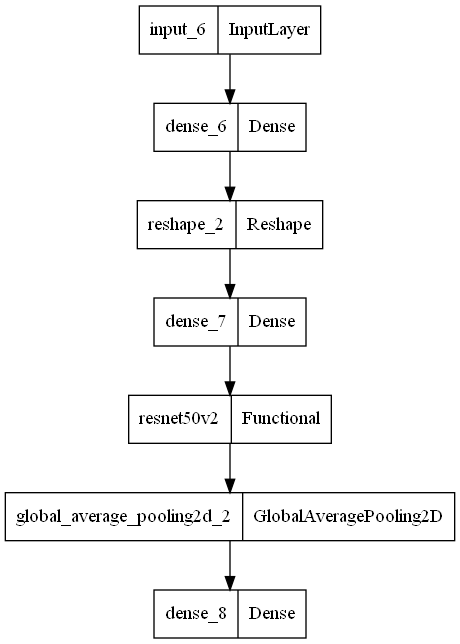

In [21]:
tf.keras.utils.plot_model(model, to_file="model.png")

In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=1, factor=0.5, min_lr=5e-5)
checkpoint = ModelCheckpoint('backup/modelo_prueba{epoch:08d}.h5', 
                             save_freq = 'epoch', save_best_only=True, mode='min') 

In [23]:
history = model.fit(X_train, y_train, epochs = 500, batch_size = 128, 
                    callbacks=[learning_rate_reduction, early_stopping, checkpoint],
                    validation_data= (X_test, y_test))

Epoch 1/500
8/8 [==============================] - 220s 27s/step - loss: 21440.6992 - mae: 21440.6992 - val_loss: 19413.2949 - val_mae: 19413.2949 - lr: 0.0100
Epoch 2/500
8/8 [==============================] - 211s 27s/step - loss: 21386.5117 - mae: 21386.5117 - val_loss: 19343.1055 - val_mae: 19343.1055 - lr: 0.0100
Epoch 3/500
8/8 [==============================] - 208s 27s/step - loss: 21308.1270 - mae: 21308.1270 - val_loss: 19256.0234 - val_mae: 19256.0234 - lr: 0.0100
Epoch 4/500
8/8 [==============================] - 219s 27s/step - loss: 21217.2344 - mae: 21217.2344 - val_loss: 19159.5059 - val_mae: 19159.5059 - lr: 0.0100
Epoch 5/500
8/8 [==============================] - 240s 31s/step - loss: 21116.9062 - mae: 21116.9062 - val_loss: 19052.5137 - val_mae: 19052.5137 - lr: 0.0100
Epoch 6/500
8/8 [==============================] - 203s 26s/step - loss: 21007.0762 - mae: 21007.0762 - val_loss: 18940.6875 - val_mae: 18940.6875 - lr: 0.0100
Epoch 7/500
8/8 [=======================

KeyboardInterrupt: 

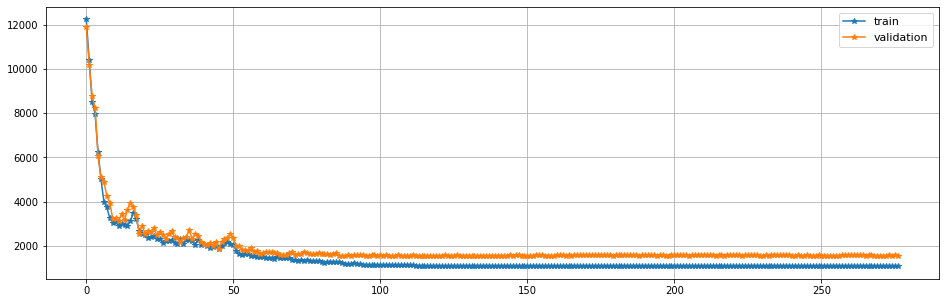

In [17]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

Fine-Tuning

In [32]:
# Unfreeze the base model
base_model.trainable = True

# Very low learning rate
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics='mae') 

history = model.fit(X_train, y_train, epochs = 10, batch_size = 64,
                    validation_data= (X_test, y_test))

Epoch 1/10
18/18 [==============================] - 48s 2s/step - loss: 770.6472 - mae: 770.6472 - val_loss: 706.7761 - val_mae: 706.7761
Epoch 2/10
18/18 [==============================] - 40s 2s/step - loss: 538.4282 - mae: 538.4282 - val_loss: 638.9774 - val_mae: 638.9774
Epoch 3/10
18/18 [==============================] - 40s 2s/step - loss: 491.7494 - mae: 491.7494 - val_loss: 601.6635 - val_mae: 601.6635
Epoch 4/10
18/18 [==============================] - 39s 2s/step - loss: 402.4189 - mae: 402.4189 - val_loss: 631.0978 - val_mae: 631.0978
Epoch 5/10
18/18 [==============================] - 39s 2s/step - loss: 497.1573 - mae: 497.1573 - val_loss: 567.7936 - val_mae: 567.7936
Epoch 6/10
18/18 [==============================] - 39s 2s/step - loss: 355.0837 - mae: 355.0837 - val_loss: 508.4856 - val_mae: 508.4856
Epoch 7/10
18/18 [==============================] - 40s 2s/step - loss: 328.6744 - mae: 328.6744 - val_loss: 516.9969 - val_mae: 516.9969
Epoch 8/10
18/18 [================

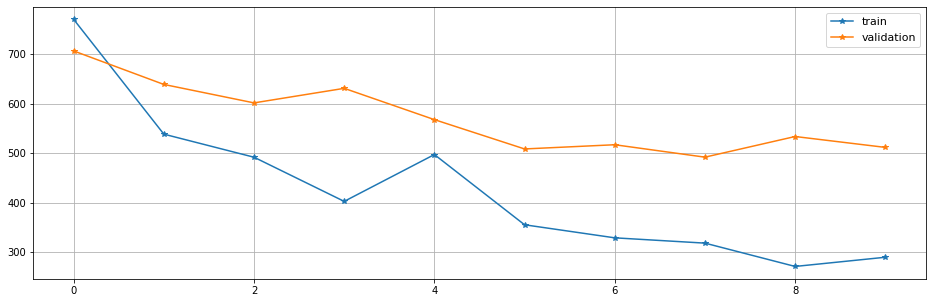

In [33]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

Predictions

In [34]:
X_new = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
y_pred_redes = model.predict(X_new, verbose=1)

43/43 [==============================] - 7s 140ms/step


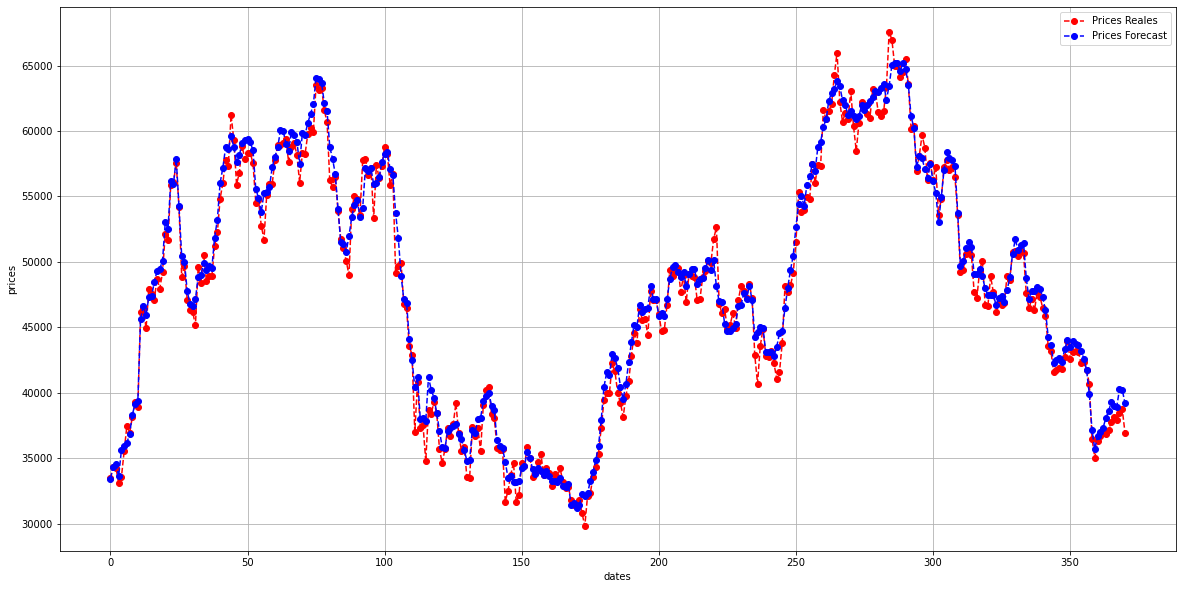

In [44]:
fig=plt.figure(figsize=(20, 10))
plt.plot(y[1000:], '--bo', label = 'Prices Reales', color = "r")
plt.plot(y_pred_redes[1000:], '--bo', label = 'Prices Forecast', color = "b")
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)
plt.savefig('imagen.png', dpi = 200)
plt.show()

In [36]:
#y_test_original = y_test * (maximo - minimo) + minimo
#y_pred_redes_ok = y_pred_redes * (maximo - minimo) + minimo
#y_pred_baseline_ok = y_pred_baseline * (maximo - minimo) + minimo

y_test_original = y_test 
y_pred_redes_ok = y_pred_redes 
#y_pred_baseline_ok = y_pred_baseline 

In [37]:
errores_redes = np.empty([len(y_test_original)])
#errores_baseline = np.empty([len(y_test_original)])
for i in range(0,len(y_test_original)):
    errores_redes[i] = np.linalg.norm(y_test_original[i] - y_pred_redes_ok[i], np.inf)
    #errores_baseline[i] = np.linalg.norm(y_test_original[i] - y_pred_baseline_ok[i], np.inf)

In [38]:
print("Errores usando Redes")
print(pd.DataFrame(errores_redes).describe().transpose().round(2))
# print("Errores usando Baseline")
# print(pd.DataFrame(errores_baseline).describe().transpose().round(2))

Errores usando Redes
   count      mean       std    min      25%      50%      75%       max
0  275.0  14933.07  19132.37  25.11  2120.58  4056.79  30130.7  60490.92


In [39]:
#s1 = errores_baseline[errores_baseline < np.percentile(errores_baseline, 95)]
s2 = errores_redes[errores_redes < np.percentile(errores_redes, 95)]

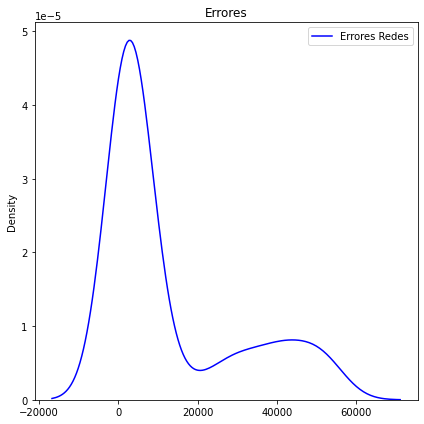

In [40]:
plt.figure(figsize=(6,6))
#sns.kdeplot(s1, color = "red",  label = 'Errores Baseline')
sns.kdeplot(s2, color = "blue", label = 'Errores Redes')
plt.title('Errores')
plt.tight_layout()
plt.legend()
plt.show()

In [41]:
# best_baseline = np.argmin(errores_baseline)
# worse_baseline = np.argmax(errores_baseline)
# print("Posicion mejor Baseline Model: " + str(best_baseline))
# print("Posicion peor Baseline Model: " + str(worse_baseline))

best_redes = np.argmin(errores_redes)
worse_redes = np.argmax(errores_redes)
print("Posicion mejor Redes Model: " + str(best_redes))
print("Posicion peor Redes Model: " + str(worse_redes))

Posicion mejor Redes Model: 86
Posicion peor Redes Model: 240


<Figure size 1440x432 with 0 Axes>

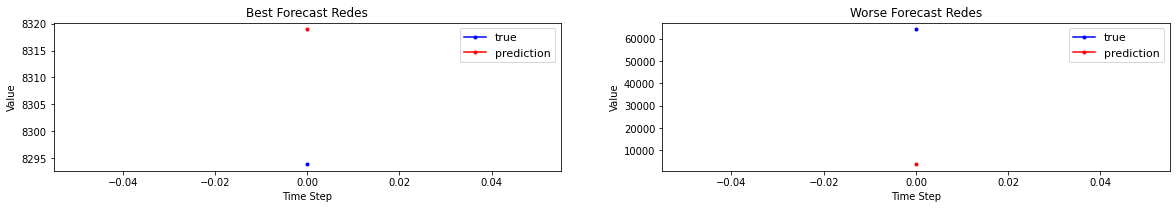

In [42]:
plt.figure(figsize=(20, 6))
#plt.subplot(111)
# plt.title("Best Forecast Baseline")
# plt.plot(y_test[best_baseline], color = "blue", marker='.', label="true")
# plt.plot(y_pred_baseline[best_baseline], color = 'red', marker = ".", label="prediction")
# plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

# plt.subplot(222)
# plt.title("Worse Forecast Baseline")
# plt.plot(y_test[worse_baseline], color = "blue", marker='.', label="true")
# plt.plot(y_pred_baseline[worse_baseline], color = 'red', marker = ".", label="prediction")
# plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.figure(figsize=(20, 6))
plt.subplot(223)
plt.title("Best Forecast Redes")
plt.plot(y_test[best_redes],  color = "blue", marker='.', label="true")
plt.plot(y_pred_redes[best_redes][0], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(224)
plt.title("Worse Forecast Redes")
plt.plot(y_test[worse_redes], color = "blue", marker='.', label="true")
plt.plot(y_pred_redes[worse_redes][0], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11) 
plt.show();